### Waste Clasification

# Importing Libraries

In [224]:
import os
import numpy  as np
import warnings
warnings.filterwarnings("ignore")

import shutil

import random
from random import seed
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.applications.vgg16 import VGG16 - in this trial, we won't use transfer learning
#from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score


Upload and classification of the dataset

In [225]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\caioe\.cache\kagglehub\datasets\techsash\waste-classification-data\versions\1


In [226]:
def list_directories(path):
    for item in os.listdir(path):
        full_path = os.path.join(path, item)
        if os.path.isdir(full_path):
            print("Diretório:", full_path)
            
            list_directories(full_path)



list_directories(path)





Diretório: C:\Users\caioe\.cache\kagglehub\datasets\techsash\waste-classification-data\versions\1\DATASET
Diretório: C:\Users\caioe\.cache\kagglehub\datasets\techsash\waste-classification-data\versions\1\DATASET\DATASET
Diretório: C:\Users\caioe\.cache\kagglehub\datasets\techsash\waste-classification-data\versions\1\DATASET\DATASET\TEST
Diretório: C:\Users\caioe\.cache\kagglehub\datasets\techsash\waste-classification-data\versions\1\DATASET\DATASET\TEST\O
Diretório: C:\Users\caioe\.cache\kagglehub\datasets\techsash\waste-classification-data\versions\1\DATASET\DATASET\TEST\R
Diretório: C:\Users\caioe\.cache\kagglehub\datasets\techsash\waste-classification-data\versions\1\DATASET\DATASET\TRAIN
Diretório: C:\Users\caioe\.cache\kagglehub\datasets\techsash\waste-classification-data\versions\1\DATASET\DATASET\TRAIN\O
Diretório: C:\Users\caioe\.cache\kagglehub\datasets\techsash\waste-classification-data\versions\1\DATASET\DATASET\TRAIN\R
Diretório: C:\Users\caioe\.cache\kagglehub\datasets\tec

In [227]:
# Charging and labeling: 
def load_images_from_folder(folder, label):
    images = []
    labels = []
    if not os.path.exists(folder):
        print(f"The folder {folder} doesn't exist.")
        return images, labels
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB').resize((64, 64))  # Due my pc's limitation, we will resize between 64x64
            img = np.array(img)   # Normalize values between 0 and 1
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error {img_path}: {e}")
    return images, labels

# Path to train and test

base_dir = r"C:\Users\caioe\.cache\kagglehub\datasets\techsash\waste-classification-data\versions\1\DATASET"
train_dir = os.path.join(base_dir, 'TRAIN')
test_dir = os.path.join(base_dir, 'TEST')

# Charging images -> Organic trash is cataloged by 0 and Recycled by 1

train_O, train_labels_O = load_images_from_folder(os.path.join(train_dir, 'O'), label=0)
train_R, train_labels_R = load_images_from_folder(os.path.join(train_dir, 'R'), label=1)
test_O, test_labels_O = load_images_from_folder(os.path.join(test_dir, 'O'), label=0)
test_R, test_labels_R = load_images_from_folder(os.path.join(test_dir, 'R'), label=1)

X_train = np.array(train_O + train_R)
y_train = np.array(train_labels_O + train_labels_R)
X_test = np.array(test_O + test_R)
y_test = np.array(test_labels_O + test_labels_R)






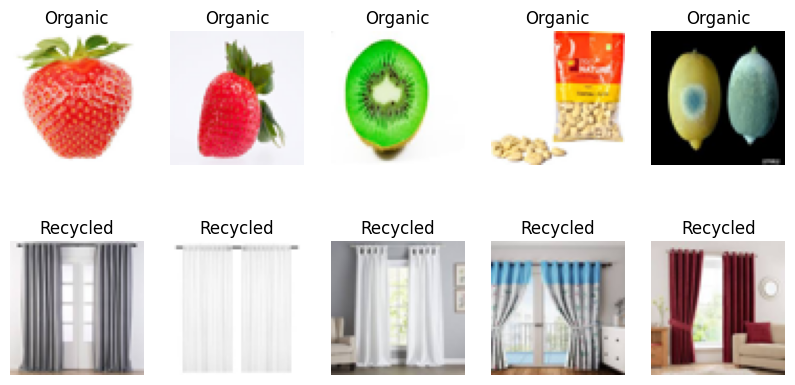

In [ ]:


def show_sample_images(images, labels, num_samples=5, class_names={0: "Organic", 1: "Recycled"}):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")
    
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(images[-(i + 1)])  
        plt.title(class_names[labels[-(i + 1)]])
        plt.axis("off")
    plt.show()


show_sample_images(X_train, y_train)


Printing some images of both dataset

In [229]:
# Verifying shapes

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (22564, 64, 64, 3)
y_train shape: (22564,)
X_test shape: (2513, 64, 64, 3)
y_test shape: (2513,)


## Data Augmentation

In [230]:



train_datagen = ImageDataGenerator(rescale=1./255, 
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  
    brightness_range=[0.6, 1.2],
    fill_mode='nearest',
    channel_shift_range=30.,
    featurewise_center=True,
    featurewise_std_normalization=True)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
test_generator = test_datagen.flow(X_test, y_test, batch_size=8)




## CNN network

In [231]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


model = Sequential()

model.add(InputLayer(shape = (64, 64, 3)))



model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Flatten())
model.add(Dense(64, activation='swish'))
model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary Classification




## Model

In [232]:
## Learning Stop


In [233]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        
    factor=0.5,                
    patience=5,                
    min_lr=1e-7              
)

In [235]:

initial_lr = 0.0005
optimizer = Adam(learning_rate=initial_lr)

In [236]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  
              metrics=['accuracy']
              ) #add early stoping

In [237]:



model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 4, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 2, 2, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 2, 2, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            6

 Total params: 50,081 (195.63 KB)

 Trainable params: 49,697 (194.13 KB)

 Non-trainable params: 384 (1.50 KB)

In [238]:

history = model.fit(
    train_generator,
    epochs=200,  
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]  
)

Epoch 1/200
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - accuracy: 0.7457 - loss: 0.5378 - val_accuracy: 0.8687 - val_loss: 0.3434 - learning_rate: 5.0000e-04
Epoch 2/200
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.7955 - loss: 0.4619 - val_accuracy: 0.8098 - val_loss: 0.4317 - learning_rate: 5.0000e-04
Epoch 3/200
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 47s 17ms/step - accuracy: 0.8065 - loss: 0.4431 - val_accuracy: 0.8623 - val_loss: 0.3358 - learning_rate: 5.0000e-04
Epoch 4/200
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - accuracy: 0.8120 - loss: 0.4253 - val_accuracy: 0.8727 - val_loss: 0.3267 - learning_rate: 5.0000e-04
Epoch 5/200
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - accuracy: 0.8183 - loss: 0.4164 - val_accuracy: 0.8762 - val_loss: 0.3126 - learning_rate: 5.0000e-04
Epoch 6/200
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 45s 16ms/step - accuracy: 0.8289 - loss: 0.4017 - val_accuracy: 0.8747 - val_loss: 0.3205 - learning_rate: 5.0000e-04
Epoch 7/200
2821/2821 ━━━━━━━━━━━━

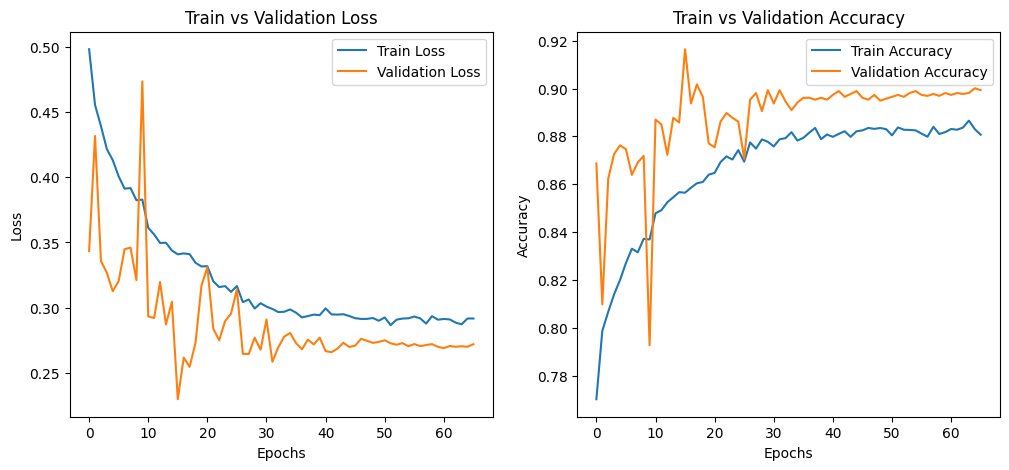

In [ ]:



plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Validation Accuracy')

plt.show()


In [241]:
# Accuracy of model

model.evaluate(X_test, y_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9252 - loss: 4.9706


[8.356895446777344, 0.8654993772506714]

Comparision between true and predicted labels

In [242]:
pred = model.predict(X_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [243]:
pred

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [244]:
pred = pred > 0.5

In [245]:
pred

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

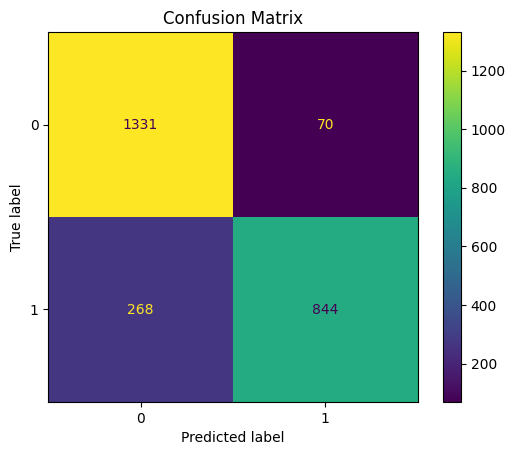

In [246]:
cm = confusion_matrix(y_test, pred )


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.viridis)  #
plt.title('Confusion Matrix')
plt.show()

In [247]:

f1 = f1_score(y_test, pred )
print(f"F1-score: {f1:.2f}")

F1-score: 0.83


In [248]:
accuracy = accuracy_score(y_test, pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.87
